In [3]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install chainer-chemistry


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import logging
from rdkit import RDLogger
from chainer_chemistry import datasets

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

logging.basicConfig(level=logging.INFO)

In [3]:
dataset_filepath = datasets.get_qm9_filepath()

print('dataset_filepath =', dataset_filepath)

dataset_filepath = C:\Users\riakh\.chainer\dataset\pfnet/chainer/qm9\qm9.csv


In [4]:
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import \
    GGNNPreprocessor
    
preprocessor = GGNNPreprocessor()
dataset, dataset_smiles = datasets.get_qm9(preprocessor, labels=None, return_smiles=True)

100%|██████████| 133885/133885 [00:26<00:00, 4987.90it/s]
INFO:chainer_chemistry.dataset.parsers.data_frame_parser:Preprocess finished. FAIL 0, SUCCESS 133885, TOTAL 133885


In [5]:
print('dataset information...')
print('dataset', type(dataset), len(dataset))

print('smiles information...')
print('dataset_smiles', type(dataset_smiles), len(dataset_smiles))

dataset information...
dataset <class 'chainer_chemistry.datasets.numpy_tuple_dataset.NumpyTupleDataset'> 133885
smiles information...
dataset_smiles <class 'numpy.ndarray'> 133885


In [6]:
print('length of dataset:', len(dataset))

length of dataset: 133885


In [7]:
# Print first 5 SMILES strings
for i in range(5):
    print(f"SMILES {i+1}: {dataset_smiles[i]}")


SMILES 1: C
SMILES 2: N
SMILES 3: O
SMILES 4: C#C
SMILES 5: C#N


In [ ]:
from rdkit import Chem


for smile in dataset_smiles:
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:  
        print(Chem.MolToInchiKey(mol))  


In [ ]:
print("Total number of SMILES:", len(dataset_smiles))
print("Type of dataset_smiles:", type(dataset_smiles))


In [ ]:
from IPython.display import display

molecules = [Chem.MolFromSmiles(smile) for smile in dataset_smiles[:5] if smile]
img = Draw.MolsToGridImage(molecules, molsPerRow=5, useSVG=True)  
display(img)


In [9]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Assuming 'dataset_smiles' is a list of SMILES strings
print("First few SMILES entries:")
for i, smiles in enumerate(dataset_smiles[:5]): 
    print(f"{i + 1}: {smiles}")


In [ ]:

print("First few entries of the dataset:")
for i in range(min(5, len(dataset))):  
    print(f"Entry {i}: {dataset[i]}")


In [40]:
import torch.optim.lr_scheduler as lr_scheduler


Total graphs: 600, Total targets: 600
Epoch 1: Train Loss = 0.009577903640456497
Epoch 2: Train Loss = 0.003184310672804713
Epoch 3: Train Loss = 0.0028097752132453025
Epoch 4: Train Loss = 0.002763946109917015
Epoch 5: Train Loss = 0.002418399858288467
Validation Loss after Epoch 5: 0.002659711753949523
Epoch 6: Train Loss = 0.0024320109980180858
Epoch 7: Train Loss = 0.002509925910271704
Epoch 8: Train Loss = 0.002491204172838479
Epoch 9: Train Loss = 0.0024588967324234547
Epoch 10: Train Loss = 0.002466200152412057
Validation Loss after Epoch 10: 0.0027559470501728354
Epoch 11: Train Loss = 0.0024740495602600275
Epoch 12: Train Loss = 0.002466393529903144
Epoch 13: Train Loss = 0.0024574229144491257
Epoch 14: Train Loss = 0.002453224884811789
Epoch 15: Train Loss = 0.0024484414258040487
Validation Loss after Epoch 15: 0.00272241763304919
Epoch 16: Train Loss = 0.0024419256136752666
Epoch 17: Train Loss = 0.0024361197603866456
Epoch 18: Train Loss = 0.0024309727479703723
Epoch 19: Tr

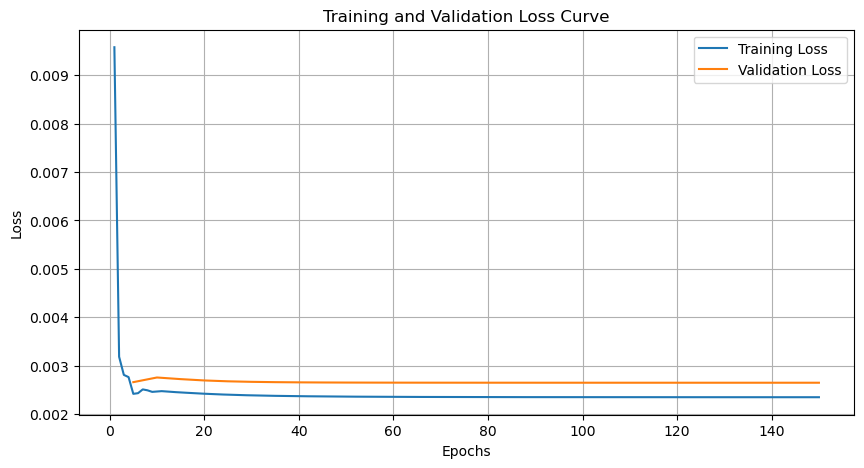

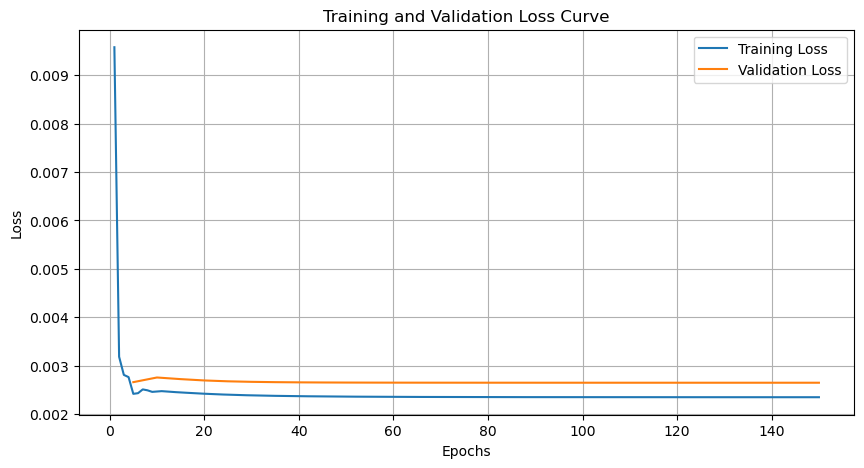

In [44]:
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
import pennylane as qml
import matplotlib.pyplot as plt


def smiles_to_graph_and_targets(smiles_list, dataset):
    data_list = []
    targets = []
    for smiles, data in zip(smiles_list, dataset):
        properties = data if len(data) > 0 else None
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        aromatics = [atom.GetIsAromatic() for atom in mol.GetAtoms()]
        hybridizations = [int(atom.GetHybridization()) for atom in mol.GetAtoms()]
        num_hydrogens = [atom.GetTotalNumHs() for atom in mol.GetAtoms()]

        x = np.column_stack([atomic_nums, aromatics, hybridizations, num_hydrogens])
        edge_index = []
        edge_attr = []
        bond_info = []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_type = bond.GetBondType()
            bond_label = {Chem.rdchem.BondType.SINGLE: 'single',
                          Chem.rdchem.BondType.DOUBLE: 'double',
                          Chem.rdchem.BondType.TRIPLE: 'triple',
                          Chem.rdchem.BondType.AROMATIC: 'aromatic'}.get(bond_type, 'single')
            bond_info.append((start, end, bond_label))
            edge_attr.append([1 if bond_label == bl else 0 for bl in ['single', 'double', 'triple', 'aromatic']])
            edge_index.append([start, end])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        x = torch.tensor(x, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, bond_info=bond_info)
        data_list.append(data)

        if properties is not None:
            target_value = properties[2][7]  # the target is in the 7th column of the third block
            targets.append(target_value)

    targets = torch.tensor(targets, dtype=torch.float)
    return data_list, targets

def split_data(graph_data, targets, train_size, val_size):
    print(f"Total graphs: {len(graph_data)}, Total targets: {len(targets)}")
    indices = np.random.permutation(len(graph_data))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]

    train_data = [graph_data[i] for i in train_indices]
    train_targets = targets[train_indices]
    val_data = [graph_data[i] for i in val_indices]
    val_targets = targets[val_indices]

    return (train_data, train_targets), (val_data, val_targets)

def filter_graphs_by_num_atoms(graph_data, targets, num_atoms=6):
    filtered_graphs = [graph for graph in graph_data if graph.num_nodes == num_atoms]
    filtered_targets = [targets[i] for i, graph in enumerate(graph_data) if graph.num_nodes == num_atoms]
    return filtered_graphs, torch.tensor(filtered_targets, dtype=torch.float)

def batch_processing(graph_data, targets, batch_size):
    num_batches = len(graph_data) // batch_size
    for i in range(num_batches):
        batch_data = graph_data[i * batch_size: (i + 1) * batch_size]
        batch_targets = targets[i * batch_size: (i + 1) * batch_size]
        yield batch_data, batch_targets

def quantum_encode(features, use_atomic_num=True, use_nh=False, use_aromaticity=True, use_hybridization=True):
    encoded_params = []
    for feature in features:
        z, nh, aromatic, hybridization = feature.tolist()
        ry_angle, rz_angle = 0, 0

        if use_atomic_num and not use_nh and use_aromaticity and use_hybridization:
            ry_angle = (2 * z - 7) * np.pi / 4 if z is not None else 0
            rz_angle = (-1)**(2 * hybridization - 1) * np.pi / 6 if hybridization is not None else 0
        elif use_atomic_num and use_nh:
            ry_angle = (2 * z - 7) * np.pi / 4 if z is not None else 0
            rz_angle = 2 * np.pi * nh / 5 if nh is not None else 0
        elif use_atomic_num:
            if z in [5, 6, 7]:
                ry_angle = np.cos(-1 / 3)
            if z == 6:
                rz_angle = 2 * np.pi / 3
            elif z == 7:
                rz_angle = -2 * np.pi / 3

        encoded_params.append([ry_angle, rz_angle])
    return np.array(encoded_params)

def default_EDU(bond_params, rzz_param, wires):
    #if len(wires) < 2:
        #raise ValueError(f"Expected 'wires' to contain at least 2 elements, but got {len(wires)} elements: {wires}")
    
    #print(f"Applying EDU on wires: {wires}")
    
    qml.RZ(bond_params[0], wires=wires[0])
    qml.RX(bond_params[1], wires=wires[0])
    qml.RZ(bond_params[0], wires=wires[1])
    qml.RX(bond_params[1], wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RZ(rzz_param, wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RX(bond_params[0], wires=wires[0])
    qml.RZ(bond_params[1], wires=wires[0])
    qml.RX(bond_params[0], wires=wires[1])
    qml.RZ(bond_params[1], wires=wires[1])

def quantum_circuit_single(graph, layer_params):
    num_layers = 3
    num_atoms = graph.num_nodes
    dev = qml.device('default.qubit', wires=num_atoms)

    @qml.qnode(dev, interface='torch')
    def circuit():
        encoded_features = quantum_encode(graph.x)
        for i in range(num_atoms):
            qml.RY(encoded_features[i][0], wires=i)
            qml.RZ(encoded_features[i][1], wires=i)

        for layer in range(num_layers):
            rzz_param = layer_params['rzz_params'][layer]
            for i in range(num_atoms):
                qml.U3(layer_params['theta'][layer], layer_params['phi'][layer], layer_params['omega'][layer], wires=i)
            bond_order = ['single', 'aromatic', 'double', 'triple']
            sorted_bonds = sorted(graph.bond_info, key=lambda x: bond_order.index(x[2]))
            for start, end, bond_type in sorted_bonds:
                bond_edu_params = layer_params['edu'][bond_type]
                default_EDU(bond_edu_params, rzz_param, [start, end])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_atoms)]

    qml_results = circuit()
    return torch.stack(qml_results).float()

def quantum_circuit_batch(batch_data, params):
    results = []
    for graph in batch_data:
        result = quantum_circuit_single(graph, params)
        results.append(result)
    return torch.stack(results)


def initialize_params(layers):
    params = {
        'theta': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'phi': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'omega': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'rzz_params': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'edu': {
            'single': torch.nn.Parameter(torch.rand(2), requires_grad=True),
            'aromatic': torch.nn.Parameter(torch.rand(2), requires_grad=True),
            'double': torch.nn.Parameter(torch.rand(2), requires_grad=True),
            'triple': torch.nn.Parameter(torch.rand(2), requires_grad=True)
        }
    }
    return params

def train_and_plot(train_data, train_targets, val_data, val_targets, batch_size, total_epochs=150, validate_every=5):
    layers = 3
    params = initialize_params(layers)

    all_params = []
    for key in params:
        if isinstance(params[key], dict):
            for subkey in params[key]:
                all_params.append(params[key][subkey])
        else:
            all_params.extend(params[key])

    r0 = torch.nn.Parameter(torch.tensor(0.1, requires_grad=True))
    r1 = torch.nn.Parameter(torch.tensor(0.2, requires_grad=True))
    all_params.extend([r0, r1])

    optimizer = torch.optim.Adam(all_params, lr=0.1)  
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)  

    loss_func = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(total_epochs):
        total_train_loss = 0
        train_batches = list(batch_processing(train_data, train_targets, batch_size))
        for batch_data, batch_targets in train_batches:
            optimizer.zero_grad()
            predictions = quantum_circuit_batch(batch_data, params)
            adjusted_predictions = r0 + r1 * torch.sum(predictions, dim=1) / len(predictions[0])
            loss = loss_func(adjusted_predictions, batch_targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        scheduler.step()  # Update the learning rate
        epoch_train_loss = total_train_loss / len(train_batches)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss}")

        if (epoch + 1) % validate_every == 0:
            total_val_loss = 0
            val_batches = list(batch_processing(val_data, val_targets, batch_size))
            for batch_data, batch_targets in val_batches:
                predictions = quantum_circuit_batch(batch_data, params)
                adjusted_predictions = r0 + r1 * torch.sum(predictions, dim=1) / len(predictions[0])
                loss = loss_func(adjusted_predictions, batch_targets)
                total_val_loss += loss.item()

            epoch_val_loss = total_val_loss / len(val_batches)
            val_losses.append(epoch_val_loss)
            print(f"Validation Loss after Epoch {epoch+1}: {epoch_val_loss}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(validate_every, len(val_losses) * validate_every + 1, validate_every), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()



graph_data, targets = smiles_to_graph_and_targets(dataset_smiles, dataset)
filtered_graphs, filtered_targets = filter_graphs_by_num_atoms(graph_data, targets, num_atoms=6)
assert len(filtered_graphs) >= 600, "Not enough samples with 6 atoms"
selected_graphs = filtered_graphs[:600]
selected_targets = filtered_targets[:600]
(train_data, train_targets), (val_data, val_targets) = split_data(selected_graphs, selected_targets, 300, 300)
train_and_plot(train_data, train_targets, val_data, val_targets, batch_size=30, total_epochs=150, validate_every=5)

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
import pennylane as qml
import matplotlib.pyplot as plt


def smiles_to_graph_and_targets(smiles_list, dataset):
    data_list = []
    targets = []
    for smiles, data in zip(smiles_list, dataset):
        properties = data if len(data) > 0 else None
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        aromatics = [atom.GetIsAromatic() for atom in mol.GetAtoms()]
        hybridizations = [int(atom.GetHybridization()) for atom in mol.GetAtoms()]
        num_hydrogens = [atom.GetTotalNumHs() for atom in mol.GetAtoms()]

        x = np.column_stack([atomic_nums, aromatics, hybridizations, num_hydrogens])
        edge_index = []
        edge_attr = []
        bond_info = []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_type = bond.GetBondType()
            bond_label = {Chem.rdchem.BondType.SINGLE: 'single',
                          Chem.rdchem.BondType.DOUBLE: 'double',
                          Chem.rdchem.BondType.TRIPLE: 'triple',
                          Chem.rdchem.BondType.AROMATIC: 'aromatic'}.get(bond_type, 'single')
            bond_info.append((start, end, bond_label))
            edge_attr.append([1 if bond_label == bl else 0 for bl in ['single', 'double', 'triple', 'aromatic']])
            edge_index.append([start, end])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        x = torch.tensor(x, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, bond_info=bond_info)
        data_list.append(data)

        if properties is not None:
            target_value = properties[2][7]  # the target is in the 7th column of the third block
            targets.append(target_value)

    targets = torch.tensor(targets, dtype=torch.float)
    return data_list, targets

def split_data(graph_data, targets, train_size, val_size):
    print(f"Total graphs: {len(graph_data)}, Total targets: {len(targets)}")
    indices = np.random.permutation(len(graph_data))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]

    train_data = [graph_data[i] for i in train_indices]
    train_targets = targets[train_indices]
    val_data = [graph_data[i] for i in val_indices]
    val_targets = targets[val_indices]

    return (train_data, train_targets), (val_data, val_targets)

def filter_graphs_by_num_atoms(graph_data, targets, num_atoms=[6,7]):
    filtered_graphs = [graph for graph in graph_data if graph.num_nodes == num_atoms]
    filtered_targets = [targets[i] for i, graph in enumerate(graph_data) if graph.num_nodes == num_atoms]
    return filtered_graphs, torch.tensor(filtered_targets, dtype=torch.float)

def batch_processing(graph_data, targets, batch_size):
    num_batches = len(graph_data) // batch_size
    for i in range(num_batches):
        batch_data = graph_data[i * batch_size: (i + 1) * batch_size]
        batch_targets = targets[i * batch_size: (i + 1) * batch_size]
        yield batch_data, batch_targets

def quantum_encode(features, use_atomic_num=True, use_nh=False, use_aromaticity=True, use_hybridization=True):
    encoded_params = []
    for feature in features:
        z, nh, aromatic, hybridization = feature.tolist()
        ry_angle, rz_angle = 0, 0

        if use_atomic_num and not use_nh and use_aromaticity and use_hybridization:
            ry_angle = (2 * z - 7) * np.pi / 4 if z is not None else 0
            rz_angle = (-1)**(2 * hybridization - 1) * np.pi / 6 if hybridization is not None else 0
        elif use_atomic_num and use_nh:
            ry_angle = (2 * z - 7) * np.pi / 4 if z is not None else 0
            rz_angle = 2 * np.pi * nh / 5 if nh is not None else 0
        elif use_atomic_num:
            if z in [5, 6, 7]:
                ry_angle = np.cos(-1 / 3)
            if z == 6:
                rz_angle = 2 * np.pi / 3
            elif z == 7:
                rz_angle = -2 * np.pi / 3

        encoded_params.append([ry_angle, rz_angle])
    return np.array(encoded_params)

def default_EDU(bond_params, rzz_param, wires):
    #if len(wires) < 2:
        #raise ValueError(f"Expected 'wires' to contain at least 2 elements, but got {len(wires)} elements: {wires}")
    
    #print(f"Applying EDU on wires: {wires}")
    
    qml.RZ(bond_params[0], wires=wires[0])
    qml.RX(bond_params[1], wires=wires[0])
    qml.RZ(bond_params[0], wires=wires[1])
    qml.RX(bond_params[1], wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RZ(rzz_param, wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RX(bond_params[0], wires=wires[0])
    qml.RZ(bond_params[1], wires=wires[0])
    qml.RX(bond_params[0], wires=wires[1])
    qml.RZ(bond_params[1], wires=wires[1])

def quantum_circuit_single(graph, layer_params):
    num_layers = 3
    num_atoms = graph.num_nodes
    dev = qml.device('default.qubit', wires=num_atoms)

    @qml.qnode(dev, interface='torch')
    def circuit():
        encoded_features = quantum_encode(graph.x)
        for i in range(num_atoms):
            qml.RY(encoded_features[i][0], wires=i)
            qml.RZ(encoded_features[i][1], wires=i)

        for layer in range(num_layers):
            rzz_param = layer_params['rzz_params'][layer]
            for i in range(num_atoms):
                qml.U3(layer_params['theta'][layer], layer_params['phi'][layer], layer_params['omega'][layer], wires=i)
            bond_order = ['single', 'aromatic', 'double', 'triple']
            sorted_bonds = sorted(graph.bond_info, key=lambda x: bond_order.index(x[2]))
            for start, end, bond_type in sorted_bonds:
                bond_edu_params = layer_params['edu'][bond_type]
                default_EDU(bond_edu_params, rzz_param, [start, end])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_atoms)]

    qml_results = circuit()
    return torch.stack(qml_results).float()

def quantum_circuit_batch(batch_data, params):
    results = []
    for graph in batch_data:
        result = quantum_circuit_single(graph, params)
        results.append(result)
    return torch.stack(results)


def initialize_params(layers):
    params = {
        'theta': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'phi': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'omega': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'rzz_params': [torch.nn.Parameter(torch.rand(1), requires_grad=True) for _ in range(layers)],
        'edu': {
            'single': torch.nn.Parameter(torch.rand(2), requires_grad=True),
            'aromatic': torch.nn.Parameter(torch.rand(2), requires_grad=True),
            'double': torch.nn.Parameter(torch.rand(2), requires_grad=True),
            'triple': torch.nn.Parameter(torch.rand(2), requires_grad=True)
        }
    }
    return params


 
def train_and_plot(train_data, train_targets, val_data, val_targets, batch_size, total_epochs=300, validate_every=5):
    layers = 3
    params = initialize_params(layers)

    all_params = []
    for key in params:
        if isinstance(params[key], dict):
            for subkey in params[key]:
                all_params.append(params[key][subkey])
        else:
            all_params.extend(params[key])

    r0 = torch.nn.Parameter(torch.tensor(0.1, requires_grad=True))
    r1 = torch.nn.Parameter(torch.tensor(0.2, requires_grad=True))
    all_params.extend([r0, r1])

    optimizer = torch.optim.Adam(all_params, lr=0.01)  
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)  

    loss_func = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(total_epochs):
        total_train_loss = 0
        train_batches = list(batch_processing(train_data, train_targets, batch_size))
        for batch_data, batch_targets in train_batches:
            optimizer.zero_grad()
            predictions = quantum_circuit_batch(batch_data, params)
            adjusted_predictions = r0 + r1 * torch.sum(predictions, dim=1) / len(predictions[0])
            loss = loss_func(adjusted_predictions, batch_targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        scheduler.step()  # Update the learning rate
        epoch_train_loss = total_train_loss / len(train_batches)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss}")

        if (epoch + 1) % validate_every == 0:
            total_val_loss = 0
            val_batches = list(batch_processing(val_data, val_targets, batch_size))
            for batch_data, batch_targets in val_batches:
                predictions = quantum_circuit_batch(batch_data, params)
                adjusted_predictions = r0 + r1 * torch.sum(predictions, dim=1) / len(predictions[0])
                loss = loss_func(adjusted_predictions, batch_targets)
                total_val_loss += loss.item()

            epoch_val_loss = total_val_loss / len(val_batches)
            val_losses.append(epoch_val_loss)
            print(f"Validation Loss after Epoch {epoch+1}: {epoch_val_loss}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(validate_every, len(val_losses) * validate_every + 1, validate_every), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

graph_data, targets = smiles_to_graph_and_targets(dataset_smiles, dataset)
filtered_graphs, filtered_targets = filter_graphs_by_num_atoms(graph_data, targets, num_atoms=6)
assert len(filtered_graphs) >= 600, "Not enough samples with 6 atoms"
selected_graphs = filtered_graphs[:600]
selected_targets = filtered_targets[:600]
(train_data, train_targets), (val_data, val_targets) = split_data(selected_graphs, selected_targets, 300, 300)
train_and_plot(train_data, train_targets, val_data, val_targets, batch_size=30, total_epochs=300, validate_every=5)

In [107]:
from pennylane.qnn import TorchLayer

In [30]:
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
import pennylane as qml
from pennylane.qnn import TorchLayer
import matplotlib.pyplot as plt

def smiles_to_graph_and_targets(smiles_list, dataset):
    data_list = []
    targets = []
    for smiles, data in zip(smiles_list, dataset):
        properties = data if len(data) > 0 else None
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        aromatics = [atom.GetIsAromatic() for atom in mol.GetAtoms()]
        hybridizations = [int(atom.GetHybridization()) for atom in mol.GetAtoms()]
        num_hydrogens = [atom.GetTotalNumHs() for atom in mol.GetAtoms()]

        x = np.column_stack([atomic_nums, aromatics, hybridizations, num_hydrogens])
        edge_index = []
        edge_attr = []
        bond_info = []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_type = bond.GetBondType()
            bond_label = {Chem.rdchem.BondType.SINGLE: 'single',
                          Chem.rdchem.BondType.DOUBLE: 'double',
                          Chem.rdchem.BondType.TRIPLE: 'triple',
                          Chem.rdchem.BondType.AROMATIC: 'aromatic'}.get(bond_type, 'single')
            bond_info.append((start, end, bond_label))
            edge_attr.append([1 if bond_label == bl else 0 for bl in ['single', 'double', 'triple', 'aromatic']])
            edge_index.append([start, end])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        x = torch.tensor(x, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, bond_info=bond_info)
        data_list.append(data)

        if properties is not None:
            target_value = properties[2][7]  # the target is in the 7th column of the third block
            targets.append(target_value)

    targets = torch.tensor(targets, dtype=torch.float)
    return data_list, targets

def split_data(graph_data, targets, train_size, val_size):
    print(f"Total graphs: {len(graph_data)}, Total targets: {len(targets)}")
    indices = np.random.permutation(len(graph_data))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]

    train_data = [graph_data[i] for i in train_indices]
    train_targets = targets[train_indices]
    val_data = [graph_data[i] for i in val_indices]
    val_targets = targets[val_indices]

    return (train_data, train_targets), (val_data, val_targets)

def filter_graphs_by_num_atoms(graph_data, targets, num_atoms=6):
    filtered_graphs = [graph for graph in graph_data if graph.num_nodes == num_atoms]
    filtered_targets = [targets[i] for i, graph in enumerate(graph_data) if graph.num_nodes == num_atoms]
    return filtered_graphs, torch.tensor(filtered_targets, dtype=torch.float)

def batch_processing(graph_data, targets, batch_size):
    num_batches = len(graph_data) // batch_size
    for i in range(num_batches):
        batch_data = graph_data[i * batch_size: (i + 1) * batch_size]
        batch_targets = targets[i * batch_size: (i + 1) * batch_size]
        yield batch_data, batch_targets

def quantum_encode(features, use_atomic_num=True, use_nh=False, use_aromaticity=True, use_hybridization=True):
    encoded_params = []
    # for feature in features:
    #     print('999999999999999999999999')
    #     if isinstance(feature, np.ndarray):
    #         print('xxxxxxxxxxxxxxxxxxxxxx')
    #         feature = feature.tolist()  # Convert numpy array to list
    
    for feature in features:
        print('Processing feature:', feature)
        if torch.is_tensor(feature):
            print('Feature is a tensor, handling directly')
        
        print('feature ',feature)
        print('debeug ::::')
        print(len(feature.unbind()))
        print(feature.unbind())
        for i in feature.unbind():
            print('i is ::',i)
            z, nh, aromatic, hybridization = i
            print('z,nh,djds',z,nh,aromatic,hybridization)
        
        ry_angle = torch.zeros_like(z)
        rz_angle = torch.zeros_like(z)

        print('88888888888888888888888')
        if use_atomic_num and not use_nh and use_aromaticity and use_hybridization:
            ry_angle = (2 * z - 7) * np.pi / 4 if z is not None else 0
            rz_angle = (-1)**(2 * hybridization - 1) * np.pi / 6 if hybridization is not None else 0
        elif use_atomic_num and use_nh:
            ry_angle = (2 * z - 7) * np.pi / 4 if z is not None else 0
            rz_angle = 2 * np.pi * nh / 5 if nh is not None else 0
        elif use_atomic_num:
            if z in [5, 6, 7]:
                ry_angle = np.cos(-1 / 3)
            if z == 6:
                rz_angle = 2 * np.pi / 3
            elif z == 7:
                rz_angle = -2 * np.pi / 3

        encoded_params.append(torch.stack([ry_angle, rz_angle], dim=1))

    return torch.cat(encoded_params, dim=0)

def default_EDU(bond_params, rzz_param, wires):
    qml.RZ(bond_params[0], wires=wires[0])
    qml.RX(bond_params[1], wires=wires[0])
    qml.RZ(bond_params[0], wires=wires[1])
    qml.RX(bond_params[1], wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RZ(rzz_param, wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RX(bond_params[0], wires=wires[0])
    qml.RZ(bond_params[1], wires=wires[0])
    qml.RX(bond_params[0], wires=wires[1])
    qml.RZ(bond_params[1], wires=wires[1])

num_layers = 3
num_atoms = 6

dev = qml.device('default.qubit', wires=num_atoms)

@qml.qnode(dev, interface='torch')
# def circuit(inputs, weights):
def circuit(inputs,weights):
    # inputs - batchsize x 8 x 4 
    # x - batchsize x 6 x 4
    # bond_info = batchsize x 13 x 3
    x=inputs[:,0:24].reshape(-1,6,4)
    print('input shape ::',)
    bond_info=inputs[:,24::].reshape(-1,13,3)
    print('shapes:',x.shape,bond_info.shape)
    # x, bond_info = inputs[0],inputs[1]

    if not isinstance(x, torch.Tensor):
        x = torch.stack([torch.flatten(graph.x) for graph in x])
    
    # x,bond_info = inputs
    print("Bond Info inside circuit:", bond_info)

    theta = weights[:num_layers]
    phi = weights[num_layers:2*num_layers]
    omega = weights[2*num_layers:3*num_layers]
    rzz_params = weights[3*num_layers:4*num_layers]
    edu_single = weights[4*num_layers:4*num_layers+2]
    edu_aromatic = weights[4*num_layers+2:4*num_layers+4]
    edu_double = weights[4*num_layers+4:4*num_layers+6]
    edu_triple = weights[4*num_layers+6:4*num_layers+8]
    
    print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$44")
    encoded_features = quantum_encode(x)
    print('sadfsdfdds')
    for i in range(num_atoms):
        qml.RY(encoded_features[i][0], wires=i)
        qml.RZ(encoded_features[i][1], wires=i)

    print('***************************')
    for layer in range(num_layers):
        for i in range(num_atoms):
            qml.U3(theta[layer], phi[layer], omega[layer], wires=i)
        # bond_order = ['single', 'aromatic', 'double', 'triple']
        # sorted_bonds = sorted(bond_info, key=lambda x: bond_order.index(x[2]))
        # for start, end, bond_type in sorted_bonds:
        #     bond_edu_params = {
        #         'single': edu_single,
        #         'aromatic': edu_aromatic,
        #         'double': edu_double,
        #         'triple': edu_triple
        #     }[bond_type]
        #     default_EDU(bond_edu_params, rzz_params[layer], [start, end])
        for bond in bond_info:
            start, end, bond_type_idx = bond[:, 0], bond[:, 1], bond[:, 2]
            # Only process bonds that are not padded (-1 padding used)
            valid_bonds= start >= 0
            start, end, bond_type_idx = start[valid_bonds], end[valid_bonds], bond_type_idx[valid_bonds]
            
            # Apply EDU based on bond type
            for s, e, b_type in zip(start, end, bond_type_idx):
                bond_type = {0: 'single', 1: 'double', 2: 'triple', 3: 'aromatic'}[b_type.item()]
                bond_params = {
                    'single': edu_single,
                    'aromatic': edu_aromatic,
                    'double': edu_double,
                    'triple': edu_triple
                }[bond_type]
                default_EDU(bond_params, rzz_params[layer], [s.item(), e.item()])

    return [qml.expval(qml.PauliZ(i)) for i in range(num_atoms)]

# Define the shape of the trainable weights
weight_shapes = {
    'weights': 4 * num_layers + 8
}

# Define the shape of the trainable weights
# weight_shapes = {
#     'theta': num_layers,
#     'phi': num_layers,
#     'omega': num_layers,
#     'rzz_params': num_layers,
#     'edu_single': 2,
#     'edu_aromatic': 2,
#     'edu_double': 2,
#     'edu_triple': 2
# }

# print("weight_shapes=",weight_shapes)
# print("weight shape type",type(weight_shapes))
# Convert the quantum circuit to a Torch layer
qlayer = TorchLayer(circuit, weight_shapes)

class QuantumModel(torch.nn.Module):
    def __init__(self, num_atoms, num_layers):
        super(QuantumModel, self).__init__()
        self.theta = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(1), requires_grad=True) for _ in range(num_layers)])
        self.phi = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(1), requires_grad=True) for _ in range(num_layers)])
        self.omega = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(1), requires_grad=True) for _ in range(num_layers)])
        self.rzz_params = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(1), requires_grad=True) for _ in range(num_layers)])
        self.edu_single = torch.nn.Parameter(torch.randn(2), requires_grad=True)
        self.edu_aromatic = torch.nn.Parameter(torch.randn(2), requires_grad=True)
        self.edu_double = torch.nn.Parameter(torch.randn(2), requires_grad=True)
        self.edu_triple = torch.nn.Parameter(torch.randn(2), requires_grad=True)
        self.qlayer = qlayer
        self.r0 = torch.nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.r1 = torch.nn.Parameter(torch.tensor(0.2), requires_grad=True)

    def forward(self, x):
        # x, bond_info = inputs[0],inputs[1]

        # if not isinstance(x, torch.Tensor):
        #     x = torch.stack([torch.flatten(graph.x) for graph in x])
        
        # bond_type_to_int = {'single': 0, 'double': 1, 'triple': 2, 'aromatic': 3}
        # bond_info_numeric = [torch.tensor([bond_type_to_int[bond[2]] for bond in bonds], dtype=torch.long) for bonds in bond_info]
        # # bond_info_numeric = [torch.tensor([{'single': 0, 'double': 1, 'triple': 2, 'aromatic': 3}[bond[2]] for bond in bonds], dtype=torch.long) for bonds in bond_info]
    
        # bond_info_numeric = torch.nn.utils.rnn.pad_sequence(bond_info_numeric, batch_first=True, padding_value=0)

        # weights = torch.cat([
        #     torch.cat([param for param in self.theta]),
        #     torch.cat([param for param in self.phi]),
        #     torch.cat([param for param in self.omega]),
        #     torch.cat([param for param in self.rzz_params]),
        #     self.edu_single, self.edu_aromatic, self.edu_double, self.edu_triple
        # ])
        print('000000')
        # print('xtype = ', type(x),'\n bond_info_type=',type(bond_info_numeric),'\n weights type=',type(weights))
        # print('weights shape',weights.shape)
        # print('weights =,',weights)
        # print('weights=',weights)

        # result = self.qlayer([x, bond_info_numeric,weights])
        # print('bond neww',bond_info_numeric)
        result = self.qlayer(x)
        # result = self.qlayer(inputs)
        print('typr of result::',type(result))
        adjusted_predictions = self.r0 + self.r1 * torch.sum(result, dim=1) / result.shape[1]
        return adjusted_predictions

# Define the number of atoms and layers
num_atoms = 6
num_layers = 3

model = QuantumModel(num_atoms, num_layers)

def train_and_plot(train_data, train_targets, val_data, val_targets, batch_size, total_epochs, validate_every):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(total_epochs):
        total_train_loss = 0
        train_batches = batch_processing(train_data, train_targets, batch_size)
        for batch_data, batch_targets in train_batches:
            optimizer.zero_grad()
            batch_x = torch.stack([graph.x for graph in batch_data])
            batch_bond_info = [graph.bond_info for graph in batch_data]
            
            bond_type_to_int = {'single': 0, 'double': 1, 'triple': 2, 'aromatic': 3}
            max_bonds = max(len(graph.bond_info) for graph in batch_data)
            max_bonds=13 
            print('max bonds ::',max_bonds)
            # bond_info_numeric = [torch.tensor([bond_type_to_int[bond[2]] for bond in bonds], dtype=torch.long) for bonds in batch_bond_info]
            # # bond_info_numeric = [torch.tensor([{'single': 0, 'double': 1, 'triple': 2, 'aromatic': 3}[bond[2]] for bond in bonds], dtype=torch.long) for bonds in bond_info]
            # bond_info_numeric = torch.nn.utils.rnn.pad_sequence(bond_info_numeric, batch_first=True, padding_value=0)
            bond_info_numeric = []
            for graph in batch_data:
                bond_numeric = [(bond[0], bond[1], bond_type_to_int[bond[2]]) for bond in graph.bond_info]
                # Padding bond info to match the max size
                bond_numeric += [(-1, -1, -1)] * (max_bonds - len(bond_numeric))
                bond_info_numeric.append(torch.tensor(bond_numeric, dtype=torch.long))
            
            bond_info_padded = torch.stack(bond_info_numeric) 
            print("Bond Info Padded:", bond_info_padded.size())

            print("Bond Info :", bond_info_padded)

            print('dims00=',batch_x.shape,bond_info_padded.shape)

            batch_x=batch_x.view(batch_size,-1)
            bond_info_padded = bond_info_padded.view(batch_size,-1)
            print('dims=',batch_x.shape,bond_info_padded.shape)
            x=torch.cat((batch_x,bond_info_padded),1)
            print('dimssss',x.shape)
            # predictions = model([batch_x, bond_info_numeric])
            predictions = model(x)
            
            loss = loss_func(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        epoch_train_loss = total_train_loss / len(train_batches)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss}")

        if (epoch + 1) % validate_every == 0:
            total_val_loss = 0
            val_batches = list(batch_processing(val_data, val_targets, batch_size))
            for batch_data, batch_targets in val_batches:
                batch_x = torch.stack([graph.x for graph in batch_data])
                batch_bond_info = [graph.bond_info for graph in batch_data]
                predictions = model((batch_x, batch_bond_info))
                loss = loss_func(predictions, batch_targets)
                total_val_loss += loss.item()

            epoch_val_loss = total_val_loss / len(val_batches)
            val_losses.append(epoch_val_loss)
            print(f"Validation Loss after Epoch {epoch+1}: {epoch_val_loss}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(validate_every, len(val_losses) * validate_every + 1, validate_every), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
graph_data, targets = smiles_to_graph_and_targets(dataset_smiles, dataset)
filtered_graphs, filtered_targets = filter_graphs_by_num_atoms(graph_data, targets, num_atoms=6)

print(f"Number of samples with 6 atoms: {len(filtered_graphs)}")

assert len(filtered_graphs) >= 600, "Not enough samples with 6 atoms"
selected_graphs = filtered_graphs[:600]
selected_targets = filtered_targets[:600]
(train_data, train_targets), (val_data, val_targets) = split_data(selected_graphs, selected_targets, 300, 300)
train_and_plot(train_data, train_targets, val_data, val_targets, batch_size=30, total_epochs=150, validate_every=5)


Number of samples with 6 atoms: 618
Total graphs: 600, Total targets: 600
max bonds :: 13
Bond Info Padded: torch.Size([30, 13, 3])
Bond Info : tensor([[[ 0,  1,  0],
         [ 1,  2,  0],
         [ 2,  3,  0],
         ...,
         [-1, -1, -1],
         [-1, -1, -1],
         [-1, -1, -1]],

        [[ 0,  1,  2],
         [ 1,  2,  0],
         [ 2,  3,  0],
         ...,
         [-1, -1, -1],
         [-1, -1, -1],
         [-1, -1, -1]],

        [[ 0,  1,  2],
         [ 1,  2,  0],
         [ 2,  3,  0],
         ...,
         [-1, -1, -1],
         [-1, -1, -1],
         [-1, -1, -1]],

        ...,

        [[ 0,  1,  0],
         [ 1,  2,  0],
         [ 2,  3,  0],
         ...,
         [-1, -1, -1],
         [-1, -1, -1],
         [-1, -1, -1]],

        [[ 0,  1,  0],
         [ 1,  2,  0],
         [ 2,  3,  2],
         ...,
         [-1, -1, -1],
         [-1, -1, -1],
         [-1, -1, -1]],

        [[ 0,  1,  0],
         [ 1,  2,  1],
         [ 1,  3,  0],
   

ValueError: too many values to unpack (expected 4)

In [28]:
def print_max_bonds_for_all_batches(graph_data, batch_size):
    num_batches = len(graph_data) // batch_size
    max_bonds_per_batch = []
    for i in range(num_batches):
        batch_data = graph_data[i * batch_size: (i + 1) * batch_size]
        max_bonds = max(len(graph.bond_info) for graph in batch_data)
        max_bonds_per_batch.append(max_bonds)
    
    for i, max_bonds in enumerate(max_bonds_per_batch):
        print(f"Batch {i + 1}/{num_batches} has a maximum of {max_bonds} bonds.")
    
    return max_bonds_per_batch

# Example usage:
max_bonds_list = print_max_bonds_for_all_batches(graph_data, batch_size=30)


Batch 1/4462 has a maximum of 3 bonds.
Batch 2/4462 has a maximum of 5 bonds.
Batch 3/4462 has a maximum of 5 bonds.
Batch 4/4462 has a maximum of 6 bonds.
Batch 5/4462 has a maximum of 5 bonds.
Batch 6/4462 has a maximum of 6 bonds.
Batch 7/4462 has a maximum of 6 bonds.
Batch 8/4462 has a maximum of 6 bonds.
Batch 9/4462 has a maximum of 5 bonds.
Batch 10/4462 has a maximum of 6 bonds.
Batch 11/4462 has a maximum of 7 bonds.
Batch 12/4462 has a maximum of 5 bonds.
Batch 13/4462 has a maximum of 5 bonds.
Batch 14/4462 has a maximum of 6 bonds.
Batch 15/4462 has a maximum of 6 bonds.
Batch 16/4462 has a maximum of 7 bonds.
Batch 17/4462 has a maximum of 7 bonds.
Batch 18/4462 has a maximum of 5 bonds.
Batch 19/4462 has a maximum of 6 bonds.
Batch 20/4462 has a maximum of 6 bonds.
Batch 21/4462 has a maximum of 6 bonds.
Batch 22/4462 has a maximum of 7 bonds.
Batch 23/4462 has a maximum of 7 bonds.
Batch 24/4462 has a maximum of 9 bonds.
Batch 25/4462 has a maximum of 6 bonds.
Batch 26/

Plotting the circuit

Angle Extraction Network

In [ ]:
import torch
import torch.nn as nn

class AngleExtractionNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Linear(128, output_features)
        )
    
    def forward(self, x):
        return self.layer(x)


In [ ]:
import pennylane as qml

def setup_quantum_circuit(num_qubits):
    dev = qml.device('default.qubit', wires=num_qubits)

    @qml.qnode(dev)
    def quantum_circuit(angle_params,edge_features, edge_indices):
        for i in range(num_qubits):
            qml.RY(angle_params[i, 0], wires=i)
            qml.RZ(angle_params[i, 1], wires=i)
            
        
        for layer in range(layers):
            if edge_indices.shape[1] > 0:
                for k in range(edge_indices.shape[1]):
                    start, end = edge_indices[0, k], edge_indices[1, k]
                    bond_type = edge_features[k]
                    if bond_type[0] == 1:
                        qml.CNOT(wires=[start, end])
                        qml.RY(angle_params[start][0], wires=end)
                    elif bond_type[1] == 1:
                        qml.CNOT(wires=[start, end])
                        qml.RZ(angle_params[start][1], wires=end)
                    if len(angle_params[start]) > 2 and bond_type[2] == 1:
                        qml.CNOT(wires=[start, end])
                        qml.RX(angle_params[start][2] * layer, wires=end)
                    if len(angle_params[start]) > 3 and bond_type[3] == 1:
                        qml.CNOT(wires=[start, end])
                        qml.Rot(angle_params[start][3] * layer, angle_params[start][3] * layer, angle_params[start][3] * layer, wires=end)

        return [qml.expval(qml.PauliZ(wires=i)) for i in range(num_qubits)]
    

    return quantum_circuit


In [ ]:
def integrate_classical_quantum(graph_data, angle_extractor):
    for i, graph in enumerate(graph_data[:10]):  
        features_np = graph.x.numpy()  
        features_torch = torch.from_numpy(features_np).float()
        
        # Get angles from the neural network
        angles = angle_extractor(features_torch)
        
        
        angles = angles.detach().numpy()
        
        
        quantum_circuit = setup_quantum_circuit(graph.num_nodes)
        edge_features_np = graph.edge_attr.numpy()
        edge_indices_np = graph.edge_index.numpy().T
        if edge_indices_np.size == 0:
            expectations = [0] * num_qubits
        else:
            expectations = quantum_circuit(encoded_params, edge_features_np, edge_indices_np)
    
        
        
        print(f"Quantum circuit output for graph {i+1}: {expectations}")


angle_extractor = AngleExtractionNetwork(input_features=4, output_features=2)
integrate_classical_quantum(graph_data, angle_extractor)
